# Neural Collaborative Filtering
- 뉴럴 네트워크 기반 추천

```bash
# Sample Data (Colab 기준)
rm -rf /tmp/repo ./data
git clone https://github.com/KennethanCeyer/fastcampus-mlops /tmp/repo
cp -R /tmp/repo/datasets/movielens_100k ./data
```
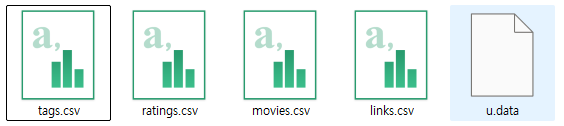

In [1]:
%conda install -y scikit-learn pandas datasets tqdm
%pip install -U matplotlib
%pip install torch

Retrieving notices: done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
class MovieLensDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1, ), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [4]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(inut_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)

In [5]:
class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
    
    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

In [6]:
class NeuralCollaborativeFiltering(torch.nn.Module):
    def __init__(self, field_dims, user_field_idx, item_field_idx, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.fc = torch.nn.Linear(mlp_dims[-1] + embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        user_x = x[:, self.user_field_idx].squeeze(1)
        item_x = x[:, self.item_field_idx].squeeze(1)
        x = self.mlp(x.view(-1, self.embed_output_dim))
        gmf = user_x * item_x
        x = torch.cat([gmf, x], dim=1)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)

In [7]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    av_loss = []
    for i, (fields, target) in enumerate(data_loader):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss = total_loss / log_interval
    av_loss.append(loss)
    total_loss = 0
    return np.mean(av_loss)

In [8]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in data_loader:
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)

In [9]:
ratings = pd.read_csv(".100k_data/ratings.csv")
dataset = MovieLensDataset(ratings)

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

learning_rate = 0.001
weight_decay = 1e-6
batch_size = 2048
epochs = 10
model_name = "ncf"

In [11]:
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_length, valid_length, test_length)
)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [12]:
model = NeuralCollaborativeFiltering(
    dataset.field_dims, embed_dim=64, mlp_dims=(32,32), dropout=0.2,
    user_field_idx=dataset.user_field_idx,
    item_field_idx=dataset.item_field_idx
).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
metric_values = []
loss_values = []
for epoch_i in tqdm(range(epochs)):
    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    metric_train = test(model, train_data_loader, device)
    metric_valid = test(model, valid_data_loader, device)
    metric_test = test(model, test_data_loader, device)

    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


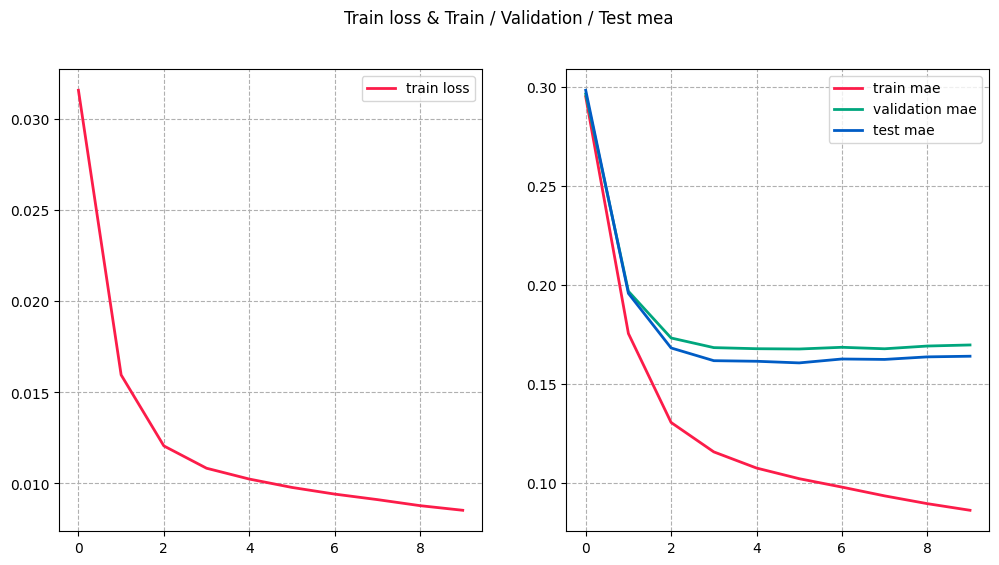

In [14]:
metric_values = np.array(metric_values)
processed_loss_values = [x[1].item() for x in loss_values]
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(processed_loss_values, label="train loss", linewidth=2, color="#fc1c49")
ax[0].legend()
ax[0].grid(linestyle="--", which="major")

ax[1].plot(metric_values[:, 1], label="train mae", linewidth=2, color="#fc1c49")
ax[1].plot(metric_values[:, 2], label="validation mae", linewidth=2, color="#00a67d")
ax[1].plot(metric_values[:, 3], label="test mae", linewidth=2, color="#005cc5")
ax[1].legend()
ax[1].grid(linestyle="--", which="major")
plt.suptitle("Train loss & Train / Validation / Test mea")
plt.show()

In [15]:
model(torch.tensor(np.array([0, 1029]).astype(np.int32)).to(device))

tensor([0.2837], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [16]:
def round_off_rating(number):
    return round(number * 2) / 2

for i, (_, row) in enumerate(ratings[ratings["userId"] == 200].iterrows()):
    print("actuel", row["rating"])
    print("pred", round_off_rating(model(torch.tensor(np.array([[row["userId"] - 1, row["movieId"] - 1]]).astype(np.int32)).to(device)).cpu().detach().numpy()[0] * 5.))
    print("===")

    if i >= 4: break

actuel 3.0
pred 3.5
===
actuel 3.5
pred 3.0
===
actuel 4.0
pred 3.5
===
actuel 3.5
pred 3.5
===
actuel 4.5
pred 3.0
===


## 모델 체크포인트 저장

In [19]:
metric_values: list[float] = []
loss_values: list[float] = []
model_save_path = "model.pth"
best_valid_loss = float("inf")

for epoch_i in tqdm(range(epochs)):
    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))

    valid_loss = test(model, valid_data_loader, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Epoch {epoch_i}: Validation loss improved, model saved ad {model_save_path}")
    
    metric_valid = test(model, valid_data_loader, device)
    metric_train = test(model, train_data_loader, device)
    metric_test = test(model, test_data_loader, device)

    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Validation loss improved, model saved ad model.path


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]
